<a href="https://colab.research.google.com/github/ikechukwuUE/steel-plate-defect/blob/master/steel_defect_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEEL DEFECT PREDICTION - kaggle

## Table of Contents

1. **Introduction**
2. **Data Preparation**
3. **Model Construction**
    - **Traditional Machine Learning Models**
    - **Neural Networks**
4. **Ensemble and Tuning**
5. **Execution**
6. **Conclusion**


## Introduction

### Project Overview
- **Objective:** Develop a sophisticated machine learning model to predict the probability of various defects on steel plates using both the competition dataset and the original Steel Plates Faults dataset from UCI.
- **Methodology:** Focus on extensive feature engineering using Principal Component Analysis (PCA) to reduce the dimensionality of the dataset and incorporate neural networks for defect prediction.
- **Expected Outcome:** A CSV file with predicted probabilities for each defect category for each id in the test set, evaluated using the area under the ROC curve (AUC) for each category.

### Version Details
- **Version Number:** 1.0
- **Configuration Parameters:** Detailed in the Configuration Parameters section.

## Imports

In [21]:
## Imports

%%time

# Installing select libraries
!pip install -q lightgbm==4.3.0 --force-reinstall
!pip install --force-reinstall scikit-learn
!pip install catboost
!pip install colorama
!pip install category_encoders
!pip install optuna

# General library imports
from gc import collect
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display_html, clear_output, Image, Markdown
clear_output()

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import sklearn as sk
import pandas as pd
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}")
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__}\n\n")
collect()

# Data manipulation and visualization
from copy import deepcopy
import numpy as np
import re
import uuid
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera
from collections import Counter
from itertools import product
from colorama import Fore, Style, init
init(autoreset=True)
import joblib
import os

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as LCM
%matplotlib inline

from pprint import pprint
from functools import partial

# Model and pipeline specifics
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, FunctionTransformer as FT, PowerTransformer
from sklearn.impute import SimpleImputer as SI
from sklearn.model_selection import RepeatedStratifiedKFold as RSKF, StratifiedKFold as SKF, StratifiedGroupKFold as SGKF, KFold, RepeatedKFold as RKF, cross_val_score, cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif as MIC, RFE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# ML Model training
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from xgboost import DMatrix, XGBClassifier as XGBC
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC
from catboost import CatBoostClassifier as CBC, Pool
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC, RandomForestClassifier as RFC

# Neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Ensemble and tuning
import optuna
from optuna import Trial, trial, create_study
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler, CmaEsSampler
optuna.logging.set_verbosity = optuna.logging.ERROR

---> XGBoost = 2.0.3 | LightGBM = 4.3.0 | Catboost = 1.2.3
---> Sklearn = 1.4.1.post1| Pandas = 1.5.3


CPU times: user 878 ms, sys: 82 ms, total: 960 ms
Wall time: 1min 8s


In [2]:
# Setting rc parameters in seaborn for plots and graphs
sns.set({"axes.facecolor": "#f7f9fc",
          "figure.facecolor": "#f7f9fc",
          "axes.edgecolor": "#000000",
          "grid.color": "#EBEBE7",
          "font.family": "serif",
          "axes.labelcolor": "#000000",
          "xtick.color": "#000000",
          "ytick.color": "#000000",
          "grid.alpha": 0.4,
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        })

# Making sklearn pipeline outputs as dataframe
from sklearn import set_config
set_config(transform_output = "pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

print()
collect()

0

In [3]:
# Color printing
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string"
    print(style + color + text + Style.RESET_ALL)

In [24]:
# Function to load and preprocess data
def load_and_preprocess_data(train_path, test_path):
    """
    Loads and preprocesses training and testing datasets.

    This function reads CSV files for training and testing datasets, performs preprocessing steps such as handling missing values and encoding categorical variables.

    Parameters:
    - train_path (str): The file path to the training dataset.
    - test_path (str): The file path to the testing dataset.

    Returns:
    - train_data (pandas.DataFrame): The preprocessed training dataset.
    - test_data (pandas.DataFrame): The preprocessed testing dataset.
    """
    # Load datasets
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Preprocessing steps (e.g., handling missing values, encoding categorical variables)
    # Example: train_data = train_data.fillna(train_data.mean())
    # Example: test_data = test_data.fillna(test_data.mean())

    return train_data, test_data

# Function to split data into features and target
def split_data(data, target_columns):
    """
    Splits a dataset into features (X) and multiple target datasets (y).

    Parameters:
    - data (pandas.DataFrame): The dataset to be split.
    - target_columns (list of str): The names of the target columns.

    Returns:
    - X (pandas.DataFrame): The features dataset.
    - y (list of pandas.Series): The target datasets.
    """
    X = data.drop(target_columns, axis=1)
    y = [data[column] for column in target_columns]
    return X, y

# Function to apply PCA
def apply_pca(X, n_components):
    """
    Applies Principal Component Analysis (PCA) to the dataset.

    Parameters:
    - X (pandas.DataFrame): The dataset to which PCA will be applied.
    - n_components (int): The number of principal components to keep.

    Returns:
    - X_pca (numpy.ndarray): The dataset transformed by PCA.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Trains a model on the training data and evaluates its performance on the test data.

    Parameters:
    - model: The machine learning model to be trained and evaluated.
    - X_train (pandas.DataFrame or numpy.ndarray): The training features dataset.
    - y_train (pandas.Series or numpy.ndarray): The training target dataset.
    - X_test (pandas.DataFrame or numpy.ndarray): The testing features dataset.
    - y_test (pandas.Series or numpy.ndarray): The testing target dataset.

    Returns:
    - accuracy (float): The accuracy of the model on the test data.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a model.

    Parameters:
    - y_test (pandas.Series or numpy.ndarray): The true target values for the test dataset.
    - y_pred_proba (numpy.ndarray): The predicted probabilities for the positive class.

    Returns:
    - None
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def create_boxplots(df):
    """
    Create boxplots for numerical columns in a DataFrame to check for outliers.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    """
    # Ensure seaborn is using matplotlib for plotting
    sns.set(style="whitegrid")

    # Select numerical columns and drop the 'id' column
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns=['id'], axis=1)

    # Create a figure and a set of subplots
    fig = plt.figure(figsize=[32,  12])
    plt.suptitle('Outliers in the data', fontsize=18, fontweight='bold')
    fig.subplots_adjust(top=0.92)
    fig.subplots_adjust(hspace=0.5, wspace=0.4)

    # Define a list of colors for the boxplots
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Iterate over the numerical columns and create a boxplot for each
    for i, col in enumerate(numeric_columns):
        ax = fig.add_subplot(3,  3, i +  1)
        ax = sns.boxplot(data=df, x=col, color=colors[i % len(colors)])
        ax.set_title(f'{col}')
        ax.set_xlabel(f'{col}')
        ax.grid(False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

def reassign_outliers(df):
    """
    Reassigns outliers in each column of a DataFrame to the 10th or 90th percentile based on the IQR.

    Parameters:
    - df: A pandas DataFrame.

    Returns:
    - A pandas DataFrame with outliers reassigned in each column.
    """
    for column in df.columns:
        # Calculate the IQR for the current column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Reassign outliers to the 10th or 90th percentile
        df.loc[df[column] < lower_bound, column] = df[column].quantile(0.10)
        df.loc[df[column] > upper_bound, column] = df[column].quantile(0.90)

    return df

def plot_correlation_heatmap(df):
    """
    Plots a correlation heatmap for a given DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame for which the correlation heatmap is to be plotted.

    Returns:
    - None
    """
    # Calculate the correlation matrix for numerical columns
    corr = df.select_dtypes(include=['float64', 'int64']).corr()

    # Create a mask to avoid repeating the lower triangle of the matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Calculate the figure size based on the number of columns
    num_columns = corr.shape[1]
    fig_size = (num_columns * 0.5, num_columns * 0.5) # Adjust the multiplier as needed

    # Create a figure and a heatmap
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm_r', cbar=None, linewidth=1, ax=ax)

    # Set the title and adjust the layout
    plt.suptitle('Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Show the plot
    plt.show()

def showplot(columnname):
    """
    Plots a donut chart and a count plot for a specified column in a DataFrame.

    This function takes a column name from a DataFrame and generates two plots:
    1. A donut chart showing the percentage distribution of the values in the column.
    2. A count plot showing the count of each unique value in the column.

    Parameters:
    - columnname (str): The name of the column in the DataFrame for which the plots are to be generated.

    Returns:
    - None
    """
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = train_df[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors = ["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']

    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%', textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35), startangle=80,   pctdistance=0.85 )
    # circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)

    # Count Plot
    sns.countplot(data=train_df, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black', fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9, color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def create_histogram(df, columnname):
    """
    Create a beautiful histogram for a given column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    columnname (str): The name of the column for which to create the histogram.
    """
    # Set seaborn style
    sns.set(style="whitegrid")

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(10,  4))

    # Create the histogram
    sns.histplot(data=df, x=columnname, bins=30, kde=True, color='#603cba', linewidth=2)

    # Set the title and labels
    ax.set_title(f'Histogram of {columnname}', fontsize=16, fontweight='bold')
    ax.set_xlabel(columnname, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)

    # Remove the top and right spines
    sns.despine(left=True, bottom=True)

    # Show the plot
    plt.show()

# Example usage

# train_data, test_data = load_and_preprocess_data('path/to/train_data.csv', 'path/to/test_data.csv')

# Assuming 'data' is your DataFrame
# X, y = split_data(data, ['target1', 'target2', 'target3'])
# Now, 'X' contains the features, and 'y' is a list of target datasets
# You can access each target dataset like this:
# y_target1 = y[0]
# y_target2 = y[1]
# y_target3 = y[2]

# X_train_pca = apply_pca(X_train, n_components=10)
# X_test_pca = apply_pca(X_test, n_components=10)

# model = RandomForestClassifier()
# accuracy = train_and_evaluate_model(model, X_train_pca, y_train, X_test_pca, y_test)
# print(f"Accuracy: {accuracy}")
# y_pred_proba = model.predict_proba(X_test_pca)

# plot_roc_curve(y_test, y_pred_proba)

# plot_correlation_heatmap(train_df)

# showplot('your_column_name')

# create_histogram(train_df, 'Age')

## Data Preparation


### Pace: Plan stage

#### Data Exploration
- **Objective:** Familiarize with the datasets, conduct initial exploratory data analysis (EDA) to understand the data structure and distribution.
- **Tasks:**
    - Load and inspect the datasets.
    - Perform basic statistical analysis.
    - Visualize data distributions.


## About Dataset
The properties of steel plates of this dataset are likely derived from image analysis and geometric measurements of steel plates. Each property provides specific information about the steel plates, which can be useful for various applications such as quality control, defect detection, and classification tasks. Here's an explanation of each property:

### Geometric Properties

- **X_Minimum**: The minimum x-coordinate of the steel plate in the image.
- **X_Maximum**: The maximum x-coordinate of the steel plate in the image.
- **Y_Minimum**: The minimum y-coordinate of the steel plate in the image.
- **Y_Maximum**: The maximum y-coordinate of the steel plate in the image.
- **Pixels_Areas**: The total number of pixels that make up the steel plate in the image.
- **X_Perimeter**: The perimeter of the steel plate along the x-axis.
- **Y_Perimeter**: The perimeter of the steel plate along the y-axis.

### Image Analysis Properties

- **Sum_of_Luminosity**: The total luminosity of the steel plate, which can be a measure of the overall brightness or contrast of the plate in the image.
- **Minimum_of_Luminosity**: The minimum luminosity value within the steel plate, indicating the darkest parts of the plate.
- **Maximum_of_Luminosity**: The maximum luminosity value within the steel plate, indicating the brightest parts of the plate.

### Additional Properties

- **Length_of_Conveyer**: The length of the conveyor belt on which the steel plate is placed. This can be important for understanding the context in which the plate is being used.
- **TypeOfSteel_A300**, **TypeOfSteel_A400**: Binary indicators (0 or 1) indicating the type of steel (e.g., A300 or A400).
- **Steel_Plate_Thickness**: The measured thickness of the steel plate.
- **Edges_Index**: A measure of the sharpness or distinctness of the edges of the steel plate in the image.
- **Empty_Index**: A measure of the emptiness or sparseness of the steel plate in the image, indicating areas with no material.
- **Square_Index**: A measure of the square-ness or uniformity of the steel plate in the image.
- **Outside_X_Index**, **Outside_Y_Index**: Measures related to the outside dimensions or characteristics of the steel plate along the x and y axes.
- **Edges_X_Index**, **Edges_Y_Index**: Measures related to the edges of the steel plate along the x and y axes.
- **Outside_Global_Index**: A global measure of the outside characteristics of the steel plate.
- **LogOfAreas**: The logarithm of the areas of the steel plate, which can be useful for normalizing the data.
- **Log_X_Index**, **Log_Y_Index**: Logarithmic measures related to the x and y dimensions or characteristics of the steel plate.
- **Orientation_Index**: A measure of the orientation of the steel plate in the image.
- **Luminosity_Index**: A measure of the luminosity of the steel plate in the image.
- **SigmoidOfAreas**: The sigmoid function applied to the areas of the steel plate, which can be useful for normalizing the data and handling outliers.

These properties provide a comprehensive set of features for analyzing steel plates, covering both geometric and image analysis aspects. They can be used individually or in combination to train machine learning models for various tasks related to steel plate quality control and defect detection.

In [6]:
# load and inspect the datasets
df_train, df_test = load_and_preprocess_data(train_path = 'https://raw.githubusercontent.com/ikechukwuUE/steel-plate-defect/master/data/train.csv',
                         test_path='https://raw.githubusercontent.com/ikechukwuUE/steel-plate-defect/master/data/test.csv')

In [10]:
# loading the uci original steel defect dataset
df_uci = pd.read_csv('https://raw.githubusercontent.com/ikechukwuUE/steel-plate-defect/master/data/Faults.tsv', sep='\t')

In [11]:
df_submissions, _ = load_and_preprocess_data(train_path = 'https://raw.githubusercontent.com/ikechukwuUE/steel-plate-defect/master/data/sample_submission.csv', test_path='https://raw.githubusercontent.com/ikechukwuUE/steel-plate-defect/master/data/test.csv')

In [12]:
display("train dataset", df_train)
print("")
display("test dataset", df_test)

'train dataset'

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.74,0.40,0.50,0.01,1.00,1.00,0.00,1.20,0.90,0.70,-0.50,-0.01,0.14,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.78,0.29,0.26,0.00,0.25,1.00,1.00,2.64,0.78,1.73,0.74,-0.30,0.95,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.06,0.53,0.99,0.11,0.24,0.39,0.00,4.06,2.18,2.21,-0.01,-0.09,1.00,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.72,0.33,0.33,0.00,0.38,0.93,1.00,2.32,0.78,1.43,0.67,-0.04,0.40,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.12,0.53,0.08,0.02,0.21,0.99,1.00,2.77,1.42,1.88,0.92,-0.25,1.00,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19214,749,757,143210,143219,17,4,4,2193,122,140,1360,0,0,50,0.90,0.15,0.86,0.00,1.00,0.80,0.00,1.23,0.78,0.60,-0.14,0.00,0.29,0,0,0,1,0,0,0
19215,19215,723,735,2488529,2488541,231,17,26,27135,104,133,1652,1,0,70,0.92,0.33,0.28,0.01,0.73,0.92,1.00,2.36,1.04,1.42,0.72,-0.10,0.54,0,0,0,0,0,0,1
19216,19216,6,31,1578055,1578129,780,114,98,71112,41,94,1358,0,1,200,0.01,0.43,0.23,0.02,0.19,0.96,1.00,2.89,1.43,1.87,0.77,-0.43,1.00,1,0,0,0,0,0,0
19217,19217,9,18,1713172,1713184,126,13,26,14808,88,132,1692,1,0,60,0.02,0.24,0.04,0.01,0.77,1.00,1.00,2.10,1.04,1.42,0.96,-0.12,0.35,0,0,0,0,0,0,1


'test dataset'

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.39,0.49,0.33,0.01,0.57,1.00,1.00,2.84,1.11,1.66,0.67,-0.23,0.92
1,19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.16,0.41,0.09,0.00,0.24,1.00,1.00,2.57,0.90,1.45,0.91,-0.15,0.91
2,19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.06,0.62,0.48,0.02,0.60,0.75,0.00,2.46,1.32,1.32,-0.52,-0.04,0.65
3,19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.44,0.33,0.82,0.00,0.80,1.00,1.00,1.90,0.70,1.04,0.18,-0.07,0.21
4,19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.82,0.26,0.43,0.02,0.84,0.53,0.00,2.15,1.32,1.15,-0.57,-0.09,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,32028,1101,1116,447943,447992,313,32,37,21603,79,103,1353,0,1,70,0.29,0.30,0.23,0.01,0.41,0.92,1.00,2.50,1.23,1.63,0.77,-0.31,0.89
12810,32029,1289,1306,3149494,3149542,59,9,18,5249,113,141,1362,0,1,40,0.01,0.28,0.28,0.01,0.78,1.00,1.00,1.77,0.85,1.26,0.72,-0.04,0.20
12811,32030,41,210,1587535,1587191,16584,796,522,1858162,24,143,1400,0,1,40,0.06,0.56,0.94,0.12,0.22,0.41,0.00,4.25,2.25,2.27,-0.06,-0.08,1.00
12812,32031,1329,1340,702237,702267,386,43,34,36875,66,124,1364,0,1,40,0.01,0.18,0.15,0.01,0.24,1.00,1.00,2.59,1.11,1.59,0.85,-0.26,0.78


In [13]:
display("uci dataset", df_uci)
print("")
display("submission dataset", df_submissions)

'uci dataset'

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.05,0.24,0.18,0.00,0.47,1.00,1.00,2.43,0.90,1.64,0.82,-0.29,0.58,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.76,0.38,0.21,0.00,0.60,0.97,1.00,2.03,0.78,1.46,0.79,-0.18,0.30,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.97,0.34,0.33,0.00,0.75,0.95,1.00,1.85,0.78,1.26,0.67,-0.12,0.21,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.73,0.44,0.16,0.01,0.54,1.00,1.00,2.25,0.85,1.65,0.84,-0.16,0.52,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.07,0.45,0.07,0.01,0.28,0.99,1.00,3.38,1.23,2.41,0.93,-0.20,1.00,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.37,0.39,0.57,0.02,0.52,0.73,0.00,2.44,1.45,1.20,-0.43,0.00,0.73,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.21,0.46,0.55,0.02,0.70,0.71,0.00,2.46,1.49,1.23,-0.45,-0.06,0.82,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.21,0.33,0.52,0.02,0.72,0.68,0.00,2.47,1.46,1.18,-0.48,0.01,0.71,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.20,0.59,0.94,0.02,0.34,0.66,0.00,2.62,1.52,1.49,-0.06,-0.02,0.99,0,0,0,0,0,0,1


'submission dataset'

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.50,0.50,0.50,0.50,0.50,0.50,0.50
1,19220,0.50,0.50,0.50,0.50,0.50,0.50,0.50
2,19221,0.50,0.50,0.50,0.50,0.50,0.50,0.50
3,19222,0.50,0.50,0.50,0.50,0.50,0.50,0.50
4,19223,0.50,0.50,0.50,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...
12809,32028,0.50,0.50,0.50,0.50,0.50,0.50,0.50
12810,32029,0.50,0.50,0.50,0.50,0.50,0.50,0.50
12811,32030,0.50,0.50,0.50,0.50,0.50,0.50,0.50
12812,32031,0.50,0.50,0.50,0.50,0.50,0.50,0.50


In [14]:
# Missing columns in the test dataset
absent_columns = set(df_train.columns) - set(df_test.columns)

absent_columns

{'Bumps',
 'Dirtiness',
 'K_Scatch',
 'Other_Faults',
 'Pastry',
 'Stains',
 'Z_Scratch'}

The missing columns in the test dataset are all 7 dependent variables.

In [15]:
df_train.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,"19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00","19,219.00"
mean,"9,609.00",709.85,753.86,"1,849,756.04","1,846,605.35","1,683.99",95.65,64.12,"191,846.68",84.81,128.65,"1,459.35",0.40,0.60,76.21,0.35,0.41,0.57,0.03,0.61,0.83,0.59,2.47,1.31,1.39,0.10,-0.14,0.57,0.08,0.06,0.18,0.03,0.03,0.25,0.34
std,"5,548.19",531.54,499.84,"1,903,553.85","1,896,295.14","3,730.32",177.82,101.05,"442,024.69",28.80,14.20,145.57,0.49,0.49,53.93,0.32,0.12,0.26,0.05,0.22,0.22,0.48,0.76,0.47,0.41,0.49,0.12,0.33,0.27,0.24,0.38,0.17,0.16,0.43,0.47
min,0.00,0.00,4.00,"6,712.00","6,724.00",6.00,2.00,1.00,250.00,0.00,39.00,"1,227.00",0.00,0.00,40.00,0.00,0.00,0.01,0.00,0.01,0.10,0.00,0.78,0.30,0.00,-0.99,-0.89,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"4,804.50",49.00,214.00,"657,468.00","657,502.00",89.00,15.00,14.00,"9,848.00",70.00,124.00,"1,358.00",0.00,0.00,40.00,0.06,0.32,0.38,0.01,0.45,0.66,0.00,1.95,1.00,1.08,-0.27,-0.19,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"9,609.00",777.00,796.00,"1,398,169.00","1,398,179.00",168.00,25.00,23.00,"18,238.00",90.00,127.00,"1,364.00",0.00,1.00,69.00,0.24,0.41,0.55,0.01,0.64,0.96,1.00,2.23,1.15,1.32,0.11,-0.14,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"14,413.50","1,152.00","1,165.00","2,368,032.00","2,362,511.00",653.00,64.00,61.00,"67,978.00",105.00,135.00,"1,652.00",1.00,1.00,80.00,0.66,0.49,0.82,0.02,0.79,1.00,1.00,2.81,1.43,1.71,0.53,-0.08,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,"19,218.00","1,705.00","1,713.00","12,987,661.00","12,987,692.00","152,655.00","7,553.00",903.00,"11,591,414.00",196.00,253.00,"1,794.00",1.00,1.00,300.00,1.00,0.93,1.00,0.67,1.00,1.00,1.00,4.55,3.00,4.03,0.99,0.64,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [16]:
df_uci.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,"1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00"
mean,571.14,617.96,"1,650,684.87","1,650,738.71","1,893.88",111.86,82.97,"206,312.15",84.55,130.19,"1,459.16",0.40,0.60,78.74,0.33,0.41,0.57,0.03,0.61,0.81,0.58,2.49,1.34,1.40,0.08,-0.13,0.59,0.08,0.10,0.20,0.04,0.03,0.21,0.35
std,520.69,497.63,"1,774,578.41","1,774,590.09","5,168.46",301.21,426.48,"512,293.59",32.13,18.69,144.58,0.49,0.49,55.09,0.30,0.14,0.27,0.06,0.24,0.23,0.48,0.79,0.48,0.45,0.50,0.15,0.34,0.27,0.30,0.40,0.19,0.17,0.41,0.48
min,0.00,4.00,"6,712.00","6,724.00",2.00,2.00,1.00,250.00,0.00,37.00,"1,227.00",0.00,0.00,40.00,0.00,0.00,0.01,0.00,0.01,0.05,0.00,0.30,0.30,0.00,-0.99,-1.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,51.00,192.00,"471,253.00","471,281.00",84.00,15.00,13.00,"9,522.00",63.00,124.00,"1,358.00",0.00,0.00,40.00,0.06,0.32,0.36,0.01,0.41,0.60,0.00,1.92,1.00,1.08,-0.33,-0.20,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,435.00,467.00,"1,204,128.00","1,204,136.00",174.00,26.00,25.00,"19,202.00",90.00,127.00,"1,364.00",0.00,1.00,70.00,0.23,0.41,0.56,0.01,0.64,0.95,1.00,2.24,1.18,1.32,0.10,-0.13,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"1,053.00","1,072.00","2,183,073.00","2,183,084.00",822.00,84.00,83.00,"83,011.00",106.00,140.00,"1,650.00",1.00,1.00,80.00,0.57,0.50,0.82,0.02,0.80,1.00,1.00,2.91,1.52,1.73,0.51,-0.07,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,"1,705.00","1,713.00","12,987,661.00","12,987,692.00","152,655.00","10,449.00","18,152.00","11,591,414.00",203.00,253.00,"1,794.00",1.00,1.00,300.00,1.00,0.94,1.00,0.88,1.00,1.00,1.00,5.18,3.07,4.26,0.99,0.64,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Cleaning the uci dataset

In [17]:
df_uci.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [18]:
df_uci.duplicated().sum()

0

In [19]:
df_uci_cleaned = reassign_outliers(df_uci)

df_uci_cleaned.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,"1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00","1,941.00"
mean,571.14,617.96,"1,473,565.78","1,473,618.48","1,487.50",79.67,53.22,"155,428.83",83.88,129.18,"1,459.16",0.40,0.60,74.85,0.33,0.41,0.57,0.03,0.61,0.81,0.58,2.49,1.33,1.40,0.08,-0.14,0.59,0.00,0.00,0.20,0.00,0.00,0.21,0.35
std,520.69,497.63,"1,183,053.91","1,183,071.32","2,488.49",101.83,56.03,"258,480.43",30.70,11.45,144.58,0.49,0.49,42.89,0.30,0.13,0.27,0.04,0.24,0.23,0.48,0.78,0.47,0.45,0.50,0.10,0.34,0.00,0.00,0.40,0.00,0.00,0.41,0.48
min,0.00,4.00,"6,712.00","6,724.00",2.00,2.00,1.00,250.00,0.00,100.00,"1,227.00",0.00,0.00,40.00,0.00,0.06,0.01,0.00,0.01,0.05,0.00,0.78,0.30,0.30,-0.99,-0.39,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,51.00,192.00,"471,253.00","471,281.00",84.00,15.00,13.00,"9,522.00",63.00,124.00,"1,358.00",0.00,0.00,40.00,0.06,0.32,0.36,0.01,0.41,0.60,0.00,1.92,1.00,1.08,-0.33,-0.20,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,435.00,467.00,"1,204,128.00","1,204,136.00",174.00,26.00,25.00,"19,202.00",90.00,127.00,"1,364.00",0.00,1.00,70.00,0.23,0.41,0.56,0.01,0.64,0.95,1.00,2.24,1.18,1.32,0.10,-0.13,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"1,053.00","1,072.00","2,183,073.00","2,183,084.00",822.00,84.00,83.00,"83,011.00",106.00,140.00,"1,650.00",1.00,1.00,80.00,0.57,0.50,0.82,0.02,0.80,1.00,1.00,2.91,1.52,1.73,0.51,-0.07,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,"1,705.00","1,713.00","4,737,382.00","4,737,394.00","6,381.00",285.00,186.00,"660,910.00",169.00,164.00,"1,794.00",1.00,1.00,175.00,1.00,0.77,1.00,0.12,1.00,1.00,1.00,4.39,2.28,2.63,0.99,0.12,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00


There are no missing values or duplicates. However, there are outliers which have been reassigned

#### Data Integration
- **Objective:** Assess the reliability of the data, consider ethical implications, and plan for data integration.
- **Tasks:**
    - Merge datasets if necessary.
    - Handle missing values.
    - Ensure data consistency.

In [20]:
# scaling up the original uci dataset
df_scaled = pd.concat([df_uci] * 5, ignore_index=True)
df_scaled['id'] = df_scaled.apply(lambda x: uuid.uuid4(), axis=1)

# Merge datasets if necessary
df_merged = pd.concat([df_train, df_scaled], ignore_index=True)

# Handle missing values
df_merged.isna().sum()
df_merged = df_merged.dropna()

# Ensure data consistency
df_merged.duplicated().sum() # handle duplicates
df_merged = df_merged.drop_duplicates()

df_merged.dtypes # validate data type

df_merged.columns

df_merged.drop(['id'], axis=1, inplace=True)

df_merged

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.74,0.40,0.50,0.01,1.00,1.00,0.00,1.20,0.90,0.70,-0.50,-0.01,0.14,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.78,0.29,0.26,0.00,0.25,1.00,1.00,2.64,0.78,1.73,0.74,-0.30,0.95,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.06,0.53,0.99,0.11,0.24,0.39,0.00,4.06,2.18,2.21,-0.01,-0.09,1.00,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.72,0.33,0.33,0.00,0.38,0.93,1.00,2.32,0.78,1.43,0.67,-0.04,0.40,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.12,0.53,0.08,0.02,0.21,0.99,1.00,2.77,1.42,1.88,0.92,-0.25,1.00,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28919,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.37,0.39,0.57,0.02,0.52,0.73,0.00,2.44,1.45,1.20,-0.43,0.00,0.73,0,0,0,0,0,0,1
28920,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.21,0.46,0.55,0.02,0.70,0.71,0.00,2.46,1.49,1.23,-0.45,-0.06,0.82,0,0,0,0,0,0,1
28921,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.21,0.33,0.52,0.02,0.72,0.68,0.00,2.47,1.46,1.18,-0.48,0.01,0.71,0,0,0,0,0,0,1
28922,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.20,0.59,0.94,0.02,0.34,0.66,0.00,2.62,1.52,1.49,-0.06,-0.02,0.99,0,0,0,0,0,0,1


## Exploratory data analysis

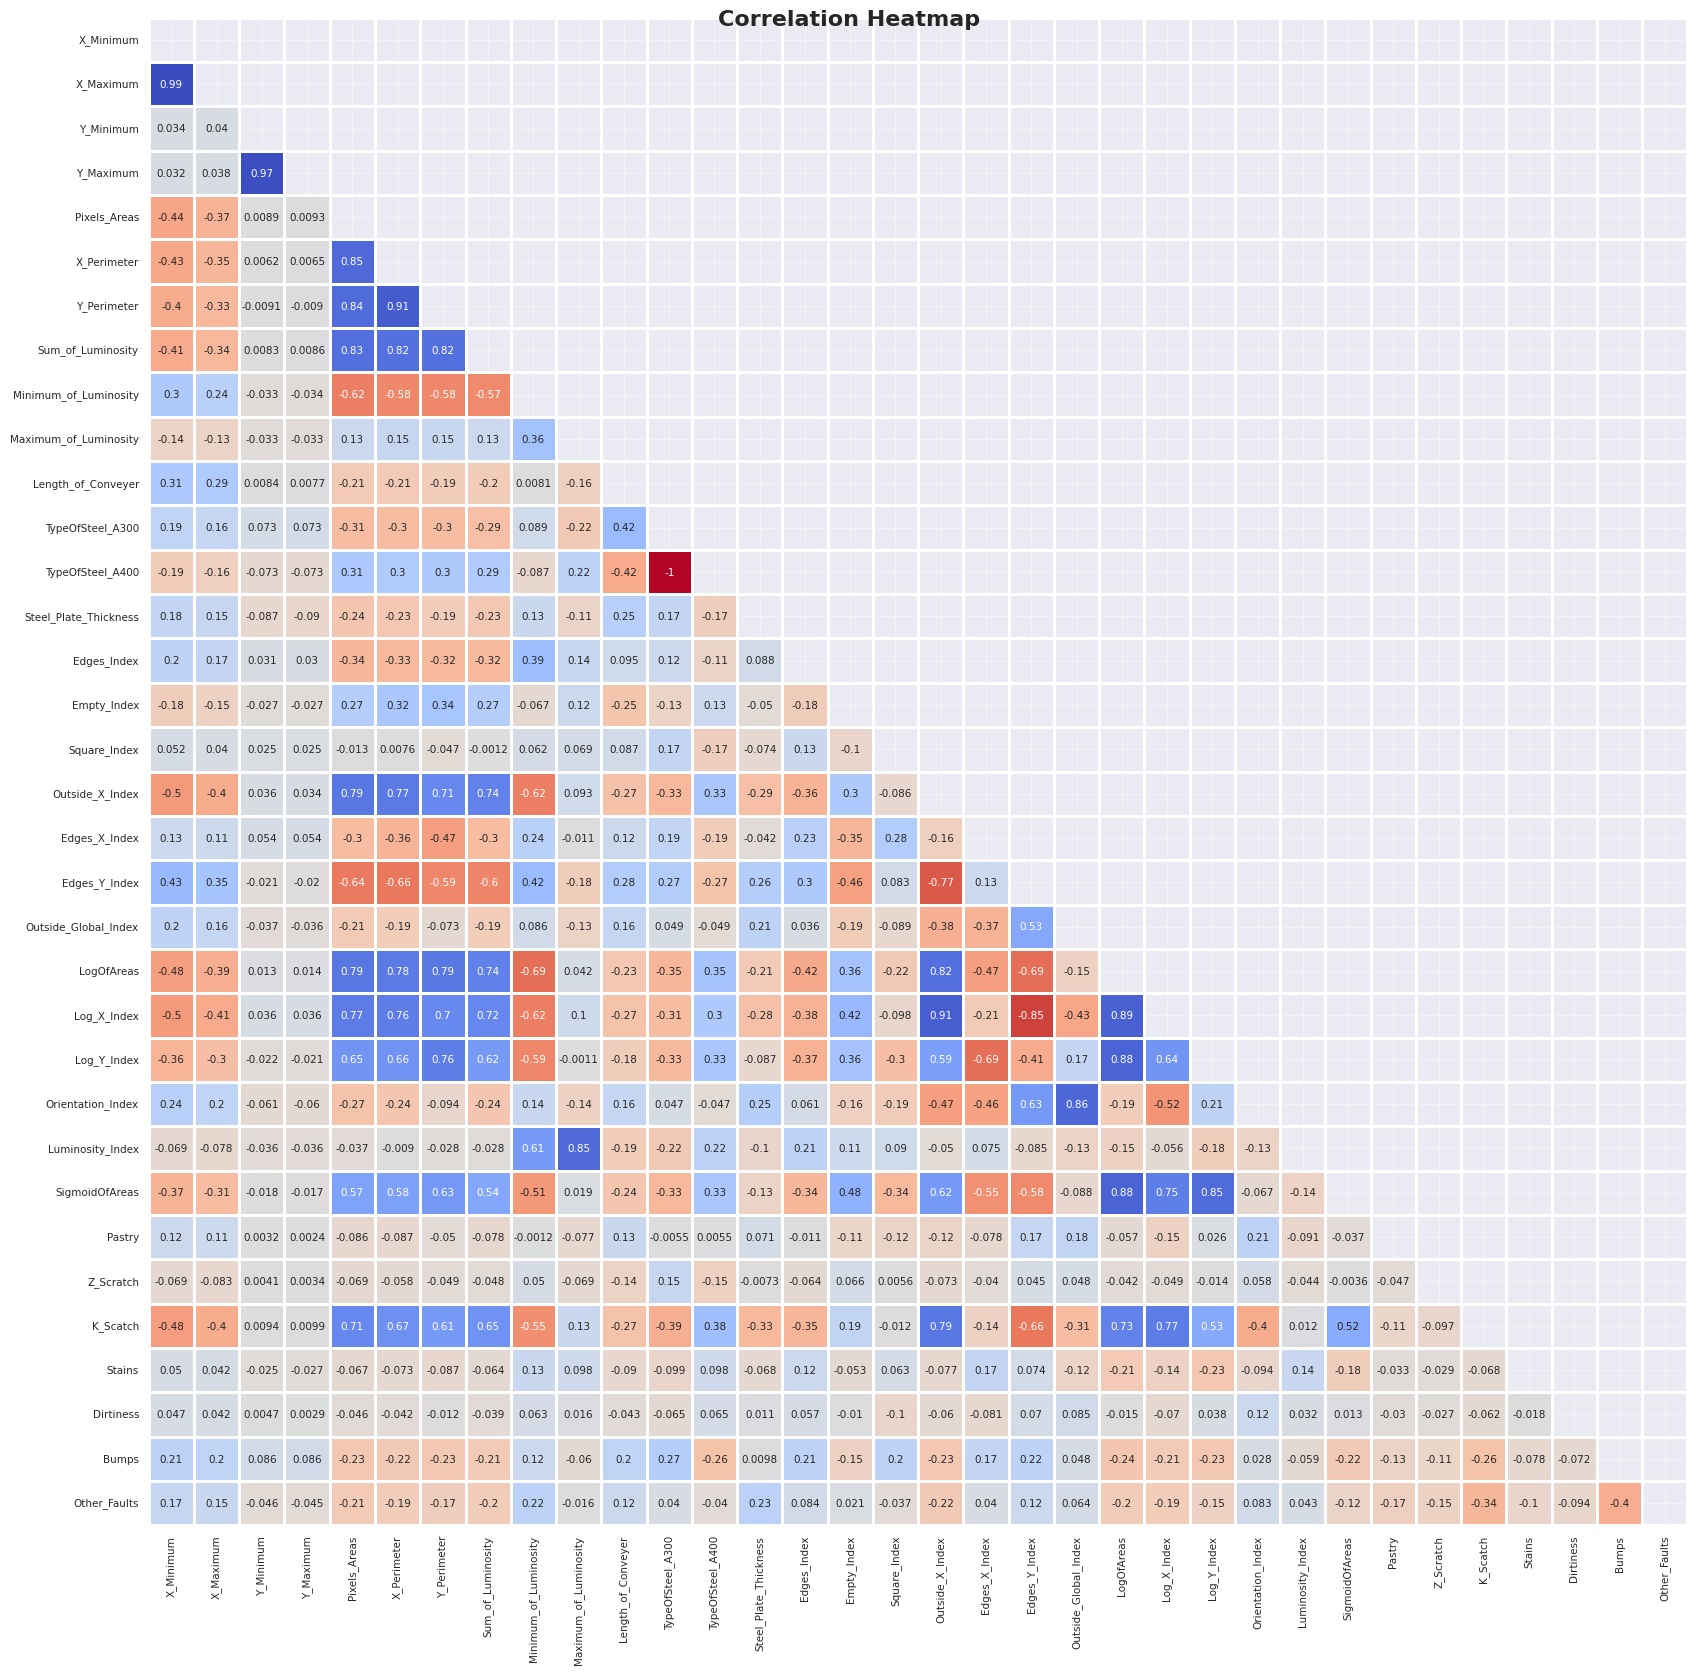

In [25]:
# constructing a correlation plot for the merged dataset

plot_correlation_heatmap(df_merged)

*   There is huge correlation between the **pixels areas, x and y perimeter and sum of luminousity with log of areas, logs of x and y indices, outside x index, and sigmoid of areas.** These also show correlation with the K_scratch target variable.
*   There is high correlation between the **outside x index and the log of areas, x and y indices, and K_scratch** as well.
*   There is huge correlation between the **outside global index and orientation index,**

Summary: dataset shows huge multicolinearity.


#### Feature Engineering
- **Objective:** Perform extensive feature engineering using PCA to reduce the dimensionality of the dataset.
- **Tasks:**
    - Select relevant features.
    - Apply PCA to reduce dimensionality.
    - Evaluate the impact of PCA on model performance.

In [ ]:
# Example code for feature engineering

# Select relevant features
# Apply PCA to reduce dimensionality
# Evaluate the impact of PCA on model performance

## Model Construction

### Construct

#### Traditional Machine Learning Models
- **Objective:** Train and evaluate traditional machine learning models.
- **Tasks:**
    - Select appropriate machine learning algorithms.
    - Define model architecture.
    - Train the model.
    - Evaluate the model.

In [ ]:
# Example code for training and evaluating traditional machine learning models

#### Neural Networks
- **Objective:** Train and evaluate neural network models for defect prediction using Keras and TensorFlow.
- **Tasks:**
    - Define neural network architecture.
    - Train the neural network model.
    - Evaluate the neural network model.


In [ ]:
# Define neural network architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100)) # Input dimension should match the number of features after PCA
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Assuming binary classification

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the neural network model
# model.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
# Evaluate the neural network model
# loss, accuracy = model.evaluate(X_test, y_test)

## Ensemble and Tuning

### Execute

#### Ensemble Strategy
- **Objective:** Combine multiple models to improve prediction accuracy.
- **Tasks:**
    - Define ensemble strategy.
    - Train ensemble models.
    - Evaluate ensemble performance.

#### Hyperparameter Tuning
- **Objective:** Optimize model parameters to improve model performance.
- **Tasks:**
    - Set up hyperparameter search space.
    - Conduct hyperparameter tuning.
    - Evaluate tuning results.

In [ ]:
# Example code for hyperparameter tuning

## Execution

### Model Execution
- **Objective:** Apply the trained model to the test dataset to make predictions.
- **Tasks:**
    - Load the test dataset.
    - Apply the model to make predictions.
    - Prepare the submission file.

In [ ]:
# Example code for model execution

### Business Recommendations
- **Objective:** Propose business recommendations based on the model's predictions.
- **Tasks:**
    - Analyze model predictions.
    - Propose actionable recommendations.

In [ ]:
# Example code for business recommendations

### Ethical Considerations
- **Objective:** Address ethical implications and ensure model ethics.
- **Tasks:**
    - Review ethical considerations.
    - Ensure model fairness and transparency.

In [ ]:
# Example code for ethical considerations

## Conclusion

### Final Thoughts
- **Objective:** Summarize the project's achievements and lessons learned.
- **Tasks:**
    - Reflect on the project's successes and challenges.
    - Discuss the impact of the project on the field of steel plate defect prediction.

### Future Work
- **Objective:** Identify areas for future research and improvement.
- **Tasks:**
    - Suggest potential improvements to the model.
    - Identify new datasets or features to explore.